In [229]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [147]:
df = pd.read_csv("/Users/CalebPitts/Documents/Files/Projects/TrafficVolume/interstate_traffic_data.csv")

In [148]:
df.shape

(48204, 9)

In [149]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


## Initial Data Cleansing

In [150]:
df["date_time"] = pd.to_datetime(df["date_time"])

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null datetime64[ns]
traffic_volume         48204 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.3+ MB


In [152]:
df[df.isnull().any(axis=1)]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume


No null values in any of the rows. 

In [153]:
df["holiday"].value_counts()

None                         48143
Labor Day                        7
New Years Day                    6
Martin Luther King Jr Day        6
Christmas Day                    6
Thanksgiving Day                 6
Columbus Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Veterans Day                     5
Name: holiday, dtype: int64

In [154]:
# converting holiday to binary value. 1 if holiday, 0 otherwise
df["holiday"] = df["holiday"].apply(lambda x: 0 if x == "None" else 1)
df["holiday"].value_counts()

0    48143
1       61
Name: holiday, dtype: int64

In [155]:
# determining quality of timestamp intervals
def get_timestamp_diffs(df):
    timestamp_diffs = df["date_time"].diff()
    print(timestamp_diffs.value_counts())

Looks like most times are 1 hour apart but there are some issues with duplicate rows, missing timestamps and a large gap of 307 days somewhere.

In [156]:
df = df.sort_values("date_time")
dups = df[df["date_time"].duplicated(keep=False)]
dups.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
178,0,281.25,0.0,0.0,99,Rain,light rain,2012-10-10 07:00:00,6793
179,0,281.25,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 07:00:00,6793
180,0,280.10,0.0,0.0,99,Rain,light rain,2012-10-10 08:00:00,6283
181,0,280.10,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 08:00:00,6283
182,0,279.61,0.0,0.0,99,Rain,light rain,2012-10-10 09:00:00,5680
183,0,279.61,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 09:00:00,5680
269,0,282.43,0.0,0.0,57,Drizzle,light intensity drizzle,2012-10-14 09:00:00,2685
270,0,282.43,0.0,0.0,57,Mist,mist,2012-10-14 09:00:00,2685
271,0,282.43,0.0,0.0,57,Haze,haze,2012-10-14 09:00:00,2685
272,0,282.33,0.0,0.0,57,Drizzle,light intensity drizzle,2012-10-14 10:00:00,3370


In [157]:
aggs = {"holiday": "sum",
        "temp": "mean",
        "rain_1h": "mean",
        "snow_1h": "mean", 
        "clouds_all": "mean",
        "weather_main": ', '.join,
        "weather_description": ', '.join,
        "traffic_volume": "mean"}

In [158]:
fixed_dups = dups.groupby("date_time").agg(aggs).reset_index()
non_dups = df[~df["date_time"].duplicated(keep=False)]  # select non duplicated rows
df_clean = non_dups.append(fixed_dups).sort_values("date_time")  # add fixed duplicated rows back to non duplicated rows

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [159]:
get_timestamp_diffs(df_clean)

0 days 01:00:00      37986
0 days 02:00:00       2192
0 days 03:00:00        201
0 days 04:00:00         59
0 days 05:00:00         33
0 days 06:00:00         17
0 days 10:00:00         13
0 days 08:00:00         13
0 days 09:00:00         12
0 days 07:00:00         10
1 days 00:00:00          4
0 days 22:00:00          4
0 days 11:00:00          4
0 days 13:00:00          3
0 days 14:00:00          3
0 days 12:00:00          2
1 days 06:00:00          2
0 days 15:00:00          2
0 days 21:00:00          2
0 days 18:00:00          1
1 days 23:00:00          1
1 days 01:00:00          1
10 days 03:00:00         1
1 days 10:00:00          1
1 days 09:00:00          1
4 days 21:00:00          1
3 days 21:00:00          1
0 days 17:00:00          1
2 days 17:00:00          1
307 days 19:00:00        1
4 days 22:00:00          1
Name: date_time, dtype: int64


In [160]:
df_clean[df_clean["date_time"].duplicated(keep=False)].shape

(0, 9)

I've now removed all duplicated rows since there are no timestamps that are the same anymore.

In [161]:
dfm = df_clean.set_index("date_time").resample("H").first().ffill()  # force time freq to be hourly for now

In [162]:
dfm.index.freq = 'H'

In [163]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Freq: H
Data columns (total 8 columns):
clouds_all             52551 non-null float64
holiday                52551 non-null float64
rain_1h                52551 non-null float64
snow_1h                52551 non-null float64
temp                   52551 non-null float64
traffic_volume         52551 non-null float64
weather_description    52551 non-null object
weather_main           52551 non-null object
dtypes: float64(6), object(2)
memory usage: 3.6+ MB


## Initial Data Exploration

In [164]:
dfm["traffic_volume"].describe()

count    52551.000000
mean      2900.771479
std       2083.158244
min          0.000000
25%        551.000000
50%       2883.000000
75%       4790.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Average traffic volume in a given hour along the interstate is about **3260 cars.**

In [165]:
# grouping data by hour in the day 1-24 to see what an average day looks like
day_hourly_avgs = dfm.groupby(dfm.index.hour).mean()

In [166]:
day_hourly_avgs

,clouds_all,holiday,rain_1h,snow_1h,temp,traffic_volume
date_time,,,,,,
0,33.005939,0.027867,0.073559,0.000087,281.781538,899.606670
1,33.053221,0.001827,0.060457,0.000101,281.420872,610.139790
2,33.543170,0.000000,0.082439,0.000101,281.095388,493.177707
3,33.365007,0.000000,0.085107,0.000037,280.574977,467.314756
4,33.905665,0.000000,0.073444,0.000023,280.310190,716.213339
5,34.468616,0.000000,0.079863,0.000023,280.077230,1799.555048
6,35.152581,0.000000,0.088095,0.000023,279.885199,3446.334856
7,38.579717,0.000000,0.083472,0.000023,280.021667,4030.610781
8,40.231613,0.000000,0.064664,0.000069,280.462201,3960.672910


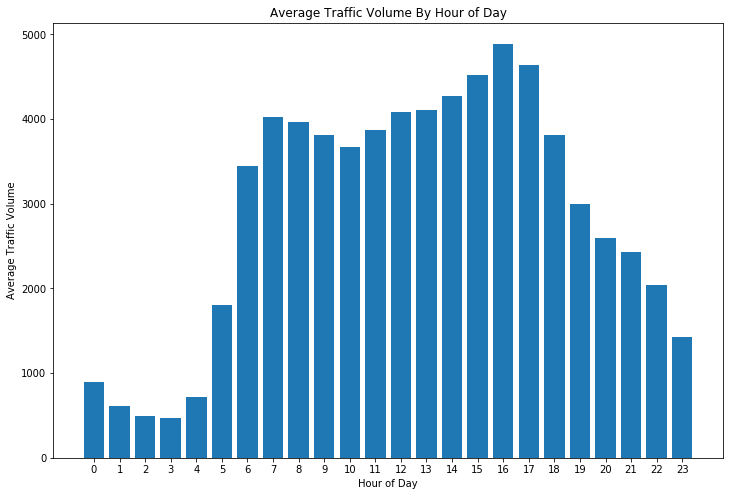

In [167]:
plt.figure(figsize=(12,8))
plt.bar(day_hourly_avgs.index, day_hourly_avgs["traffic_volume"])
plt.xticks([hour for hour in range(24)])
plt.title("Average Traffic Volume By Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Traffic Volume");

The bar chart gives an expected volume distribution with the lower volumes being night time 12-3AM and the peak volumes being 6-10AM and 3-5PM.

In [168]:
# grouping traffic volumes by day to see total volumes by day in the date series.
day_volumes = dfm.groupby(dfm.index.date).sum()

In [169]:
day_volumes

,clouds_all,holiday,rain_1h,snow_1h,temp,traffic_volume
2012-10-02,437.0,0.0,0.00,0.0,4356.05,63289.0
2012-10-03,81.0,0.0,0.00,0.0,6866.59,89097.0
2012-10-04,401.0,0.0,0.00,0.0,6944.58,89939.0
2012-10-05,1690.0,0.0,0.00,0.0,6785.44,94092.0
2012-10-06,1508.0,0.0,0.00,0.0,6666.75,75455.0
2012-10-07,1955.0,0.0,0.00,0.0,6640.49,69756.0
2012-10-08,351.0,1.0,0.00,0.0,6650.44,82135.0
2012-10-09,1584.0,0.0,0.00,0.0,6778.67,86968.0
2012-10-10,1992.0,0.0,0.00,0.0,6756.38,86504.0
2012-10-11,1090.0,0.0,0.00,0.0,6676.27,89623.0


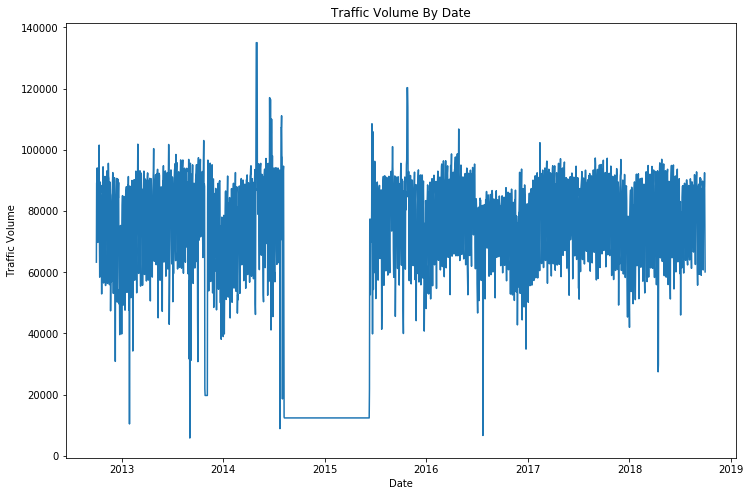

In [170]:
plt.figure(figsize=(12,8))
plt.plot(day_volumes.index, day_volumes["traffic_volume"])
plt.title("Traffic Volume By Date")
plt.xlabel("Date")
plt.ylabel("Traffic Volume");

Seems a little busy. Let's clean this up by creating a moving average and exploring the apparent gap in 2014/2015 data.

In [171]:
day_volumes["traffic_volume_r7"] = day_volumes["traffic_volume"].rolling(window=28).mean()

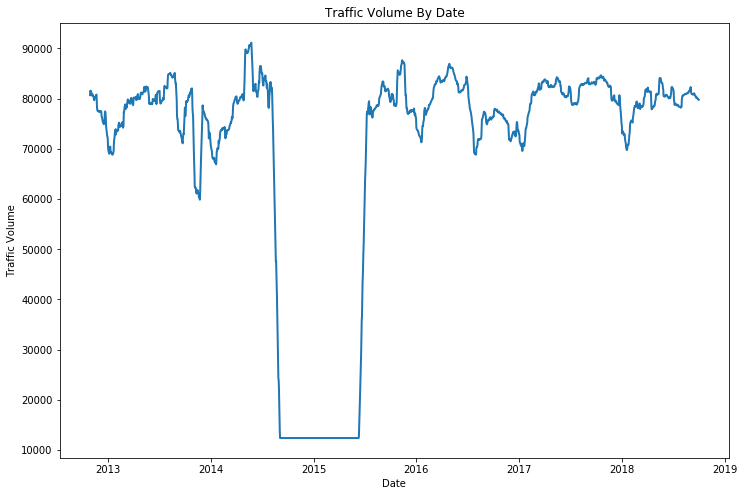

In [172]:
plt.figure(figsize=(12,8))
plt.plot(day_volumes.index, day_volumes["traffic_volume_r7"], lw=2)
plt.title("Traffic Volume By Date")
plt.xlabel("Date")
plt.ylabel("Traffic Volume");

In [185]:
dfm[dfm.traffic_volume == 516]

,clouds_all,holiday,rain_1h,snow_1h,temp,traffic_volume,weather_description,weather_main
date_time,,,,,,,,
2012-12-04 00:00:00,40.0,0.0,0.0,0.0,277.83,516.0,mist,Mist
2013-04-19 00:00:00,90.0,0.0,0.0,0.0,274.36,516.0,"light rain, heavy snow","Rain, Snow"
2013-05-25 02:00:00,1.0,0.0,0.0,0.0,280.93,516.0,sky is clear,Clear
2013-06-21 01:00:00,92.0,0.0,0.0,0.0,295.04,516.0,overcast clouds,Clouds
2013-09-15 02:00:00,90.0,0.0,0.0,0.0,287.15,516.0,"mist, moderate rain","Mist, Rain"
2013-11-18 00:00:00,90.0,0.0,0.0,0.0,272.64,516.0,overcast clouds,Clouds
2014-02-24 00:00:00,1.0,0.0,0.0,0.0,258.67,516.0,sky is clear,Clear
2014-03-01 02:00:00,90.0,0.0,0.0,0.0,256.76,516.0,overcast clouds,Clouds
2014-08-08 01:00:00,1.0,0.0,0.0,0.0,292.38,516.0,sky is clear,Clear


## Order Exploration

In [198]:
dfm_day = dfm.groupby(dfm.index.date).agg({"clouds_all": "sum", "holiday": "sum", 
                                           "rain_1h": "mean", "snow_1h": "mean", 
                                           "temp": "mean", "traffic_volume": "sum"})

In [199]:
dfm_day.index = pd.to_datetime(dfm_day.index)
dfm_day.index.freq = "D"

In [200]:
trimmed = dfm_day[dfm_day.index > '2015-06-11']
trimmed.shape

(1207, 6)

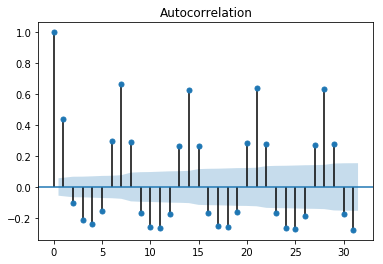

In [209]:
plot_acf(trimmed["traffic_volume"]);

There is no gradual descent in correlation, meaning I have a stationary dataset

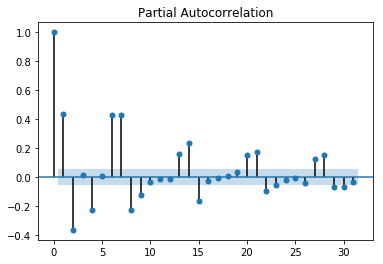

In [210]:
plot_pacf(trimmed["traffic_volume"]);

## ARIMA Model

**Train/Test Split**

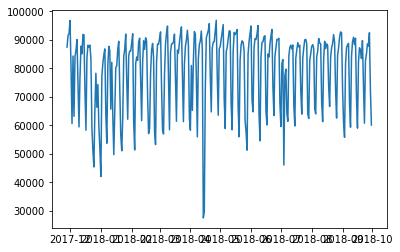

In [237]:
plt.plot(vol_data[900:])

In [211]:
vol_data = trimmed["traffic_volume"]
train = vol_data[:1117]
test = vol_data[1117:]  # prediction horizon is set to 90 days

In [216]:
auto_arima(train)

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(5, 0, 5),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [217]:
mod = ARIMA(train, order=(5, 0, 5)).fit()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [218]:
mod.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                 1117
Model:                     ARMA(5, 5)   Log Likelihood              -11610.565
Method:                       css-mle   S.D. of innovations           7850.636
Date:                Sun, 29 Sep 2019   AIC                          23245.130
Time:                        19:26:43   BIC                          23305.351
Sample:                    06-12-2015   HQIC                         23267.895
                         - 07-02-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.948e+04    536.662    148.092      0.000    7.84e+04    8.05e+04
ar.L1.traffic_volume     1.5023        nan        nan        nan         nan         nan
ar.L2.traffic_volume    -2.0060        nan        nan        nan         nan         nan
ar.L3.traffic_volume     1.8132        nan        nan        nan         nan         nan
ar.L4.traffic_volume    -1.5612        nan        nan        nan         nan         nan
ar.L5.traffic_volume     0.7000        nan        nan        nan         nan         nan
ma.L1.traffic_volume    -1.1106      0.029    -38.451      0.000      -1.167      -1.054
ma.L2.traffic_volume     1.6738      0.020     83.945      0.000       1.635       1.713
ma.L3.traffic_volume    -1.2273      0.041    -29.939      0.000      -1.308      -1.147
ma.L4.traffic_volume     1.2276      0.019     64.749      0.000       1.190       1.265
ma.L5.traffic_volume    -0.3010      0.029    -10.464      0.000      -0.357      -0.245
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2227           -0.9750j            1.0001           -0.2857
AR.2           -0.2227           +0.9750j            1.0001            0.2857
AR.3            0.6237           -0.7817j            1.0000           -0.1428
AR.4            0.6237           +0.7817j            1.0000            0.1428
AR.5            1.4282           -0.0000j            1.4282           -0.0000
MA.1           -0.2257           -0.9803j            1.0060           -0.2860
MA.2           -0.2257           +0.9803j            1.0060            0.2860
MA.3            0.6270           -0.7804j            1.0010           -0.1423
MA.4            0.6270           +0.7804j            1.0010            0.1423
MA.5            3.2759           -0.0000j            3.2759           -0.0000
-----------------------------------------------------------------------------
"""

In [221]:
predictions = mod.forecast(steps=90)[0]

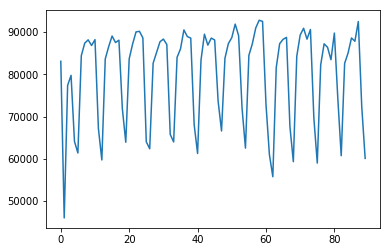

In [228]:
plt.plot(test.values)

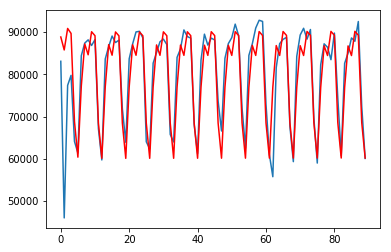

In [224]:
plt.plot(test.values)
plt.plot(predictions, c='red')

In [227]:
mean_squared_error(test.values, predictions)

38875077.90537814

In [232]:
from sklearn.utils import check_arrays

ImportError: cannot import name 'check_arrays'

In [233]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [234]:
mean_absolute_percentage_error(test.values, predictions)

5.239024362522541

## Feature Engineering

Going to encode holidays with binary value. Also going to perform one-hot encoding for both weather_main and weather_description attributes.

In [15]:
df["holiday"].unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [16]:
df["weather_main"].unique()

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Fog',
       'Thunderstorm', 'Snow', 'Squall', 'Smoke'], dtype=object)

In [14]:
df["weather_description"].unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog',
       'proximity shower rain', 'drizzle', 'moderate rain',
       'heavy intensity rain', 'proximity thunderstorm',
       'thunderstorm with light rain', 'proximity thunderstorm with rain',
       'heavy snow', 'heavy intensity drizzle', 'snow',
       'thunderstorm with heavy rain', 'freezing rain', 'shower snow',
       'light rain and snow', 'light intensity shower rain', 'SQUALLS',
       'thunderstorm with rain', 'proximity thunderstorm with drizzle',
       'thunderstorm', 'Sky is Clear', 'very heavy rain',
       'thunderstorm with light drizzle', 'light snow',
       'thunderstorm with drizzle', 'smoke', 'shower drizzle',
       'light shower snow', 'sleet'], dtype=object)

In [67]:
# ALSO ADD SEASON 1,2,3,4 decided by the date